In [ ]:
import os

import numpy as np

os.environ["ZMQ_SERVER"] = "tcp://127.0.0.1:5556"
import logging

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import HGate, XGate
from qmiotools.integrations.qiskitqmio.fakeqmio import FakeQmio
# from qmiotools.integrations.qiskitqmio.qmiobackend import QmioBackend # <- if you use the real hardware

backend = FakeQmio(
    logging_filename=None, logging_level=logging.ERROR
)  # when using the real hardware, we will use QmioBackend





logger = logging.getLogger('results')
logger.setLevel(logging.INFO)
logger.propagate = False

# File handler setup (write logs to "my_log.log")
log_file = "my_log.log"
file_handler = logging.FileHandler(log_file, mode='a')  # 'a' for append, 'w' to overwrite
file_formatter = logging.Formatter("%(asctime)s [%(levelname)s] %(message)s")
file_handler.setFormatter(file_formatter)

if not logger.handlers:
    logger.addHandler(file_handler)


logging.getLogger("qiskit").setLevel(logging.WARNING)


Importing calibrations from  ./2025_04_23__12_00_02.json


In [2]:
import hashlib
import json
import logging
from abc import ABC, abstractmethod
from dataclasses import asdict, dataclass
from datetime import datetime
from pathlib import Path
from typing import Any, Dict

import pandas as pd


class Experiment(ABC):
    @abstractmethod
    def exp_id(self) -> str:
        """Return a deterministic, unique ID for this experiment."""
        ...

    @abstractmethod
    def to_record(self, result: int, run_id: str) -> Dict[str, Any]:
        """Serialize this experiment (plus result/run_id) into a dict."""
        ...


@dataclass(
    frozen=True
)  # <- with this we make the dataclass immutable so we don't overwrite their values by accident
class myExperiment(Experiment):
    initial_state: str
    delay_time: float
    qubit_id: int
    n_shots: int

    def exp_id(self) -> str:
        dict_of_fields = asdict(self)
        hash = hashlib.sha256(
            json.dumps(dict_of_fields, sort_keys=True).encode()
        ).hexdigest()
        return hash

    def to_record(self, result: int) -> dict:
        dict_of_fields = asdict(self)
        # we now add the results to the dictionary
        dict_of_fields.update(
            {
                "result": result,
                "datetime": datetime.now().isoformat(),
                "exp_id": self.exp_id(),
            }
        )
        return dict_of_fields


logger = logging.getLogger("results")


class ResultLogger:
    def __init__(self, path, flush_interval=100):
        self.path = Path(path)
        self.flush_interval = flush_interval
        self.buffer = []

        # load existing exp_ids
        if self.path.exists():
            df = pd.read_parquet(self.path, columns=["exp_id"])
            self.done_ids = set(df["exp_id"].astype(str))
            logger.info(f"Found {len(self.done_ids)} existing experiments to skip.")
        else:
            self.done_ids = set()
            logger.info(
                "ResultLogger initialized.\n"
                "No existing results file found; starting fresh."
            )

    def log(self, exp: Experiment, result: int) -> None:
        eid = exp.exp_id()
        if eid in self.done_ids:
            return
        rec = exp.to_record(result)
        self.buffer.append(rec)
        self.done_ids.add(eid)
        logger.debug(
            f"Buffered exp_id={eid}. Buffer size: {len(self.buffer)}/{self.flush_interval}."
        )
        if len(self.buffer) >= self.flush_interval:
            logger.info(
                f"Flush interval reached ({self.flush_interval} records). "
                "Flushing to disk..."
            )
            self.flush()

    def flush(self) -> None:
        if not self.buffer:
            return
        df_new = pd.DataFrame(self.buffer)
        logger.info(f"Flushing {len(df_new)} new records to {self.path}.")
        if self.path.exists():
            df_existing = pd.read_parquet(self.path)
            df_all = pd.concat([df_existing, df_new], ignore_index=True)
            total = len(df_all)
            logger.info(
                f"Read {len(df_existing)} existing records; total will be {total}."
            )
        else:
            df_all = df_new
        self.path.parent.mkdir(parents=True, exist_ok=True)
        df_all.to_parquet(self.path, compression="zstd", index=False)
        logger.info(f"Successfully wrote {len(df_all)} total records to {self.path}.")
        self.buffer.clear()
        logger.debug("Buffer cleared after flush.")


In [3]:
path_to_save_data = "aux/temp.parquet"

logging.getLogger("qiskit").setLevel(logging.WARNING)



results_logger = ResultLogger(path_to_save_data, 1)

exp_a = myExperiment("0", 0.00001, 0, 1000)
exp_b = myExperiment("+", 0.000003, 0, 1000)

list_of_experiments = [exp_a, exp_b]

In [4]:
def make_circuit(initial_state, delay_time):
    qc = QuantumCircuit(1)
    if initial_state == "+":
        qc.append(HGate(), [0])
    qc.delay(duration=delay_time, unit="s")
    qc.measure_all()
    return qc


In [5]:
list_circuits = []
for info_circ in list_of_experiments:
    init_state_i = info_circ.initial_state
    delay_time_i = info_circ.delay_time
    ideal_circ_i = make_circuit(init_state_i, delay_time_i)
    list_circuits.append(ideal_circ_i)

list_transpiled_circuits = []
for info_circ_i, ideal_circ_i in zip(list_of_experiments, list_circuits):
    qubit_id_i = info_circ_i.qubit_id
    number_of_shots = info_circ_i.n_shots

    transpiled_circ_i = transpile(
        circuits=ideal_circ_i, backend=backend, initial_layout=[qubit_id_i]
    )
    list_transpiled_circuits.append(transpiled_circ_i)

/home/antonio/miniconda3/envs/jax-gr/lib/python3.12/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 5720 [dt] = 2.860000e-06 [s] from 2.859900e-06 [s]
  warnings.warn(
/home/antonio/miniconda3/envs/jax-gr/lib/python3.12/site-packages/qiskit/circuit/duration.py:37: UserWarning: Duration is rounded to 5720 [dt] = 2.860000e-06 [s] from 2.859900e-06 [s]
  warnings.warn(


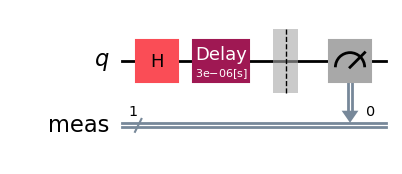

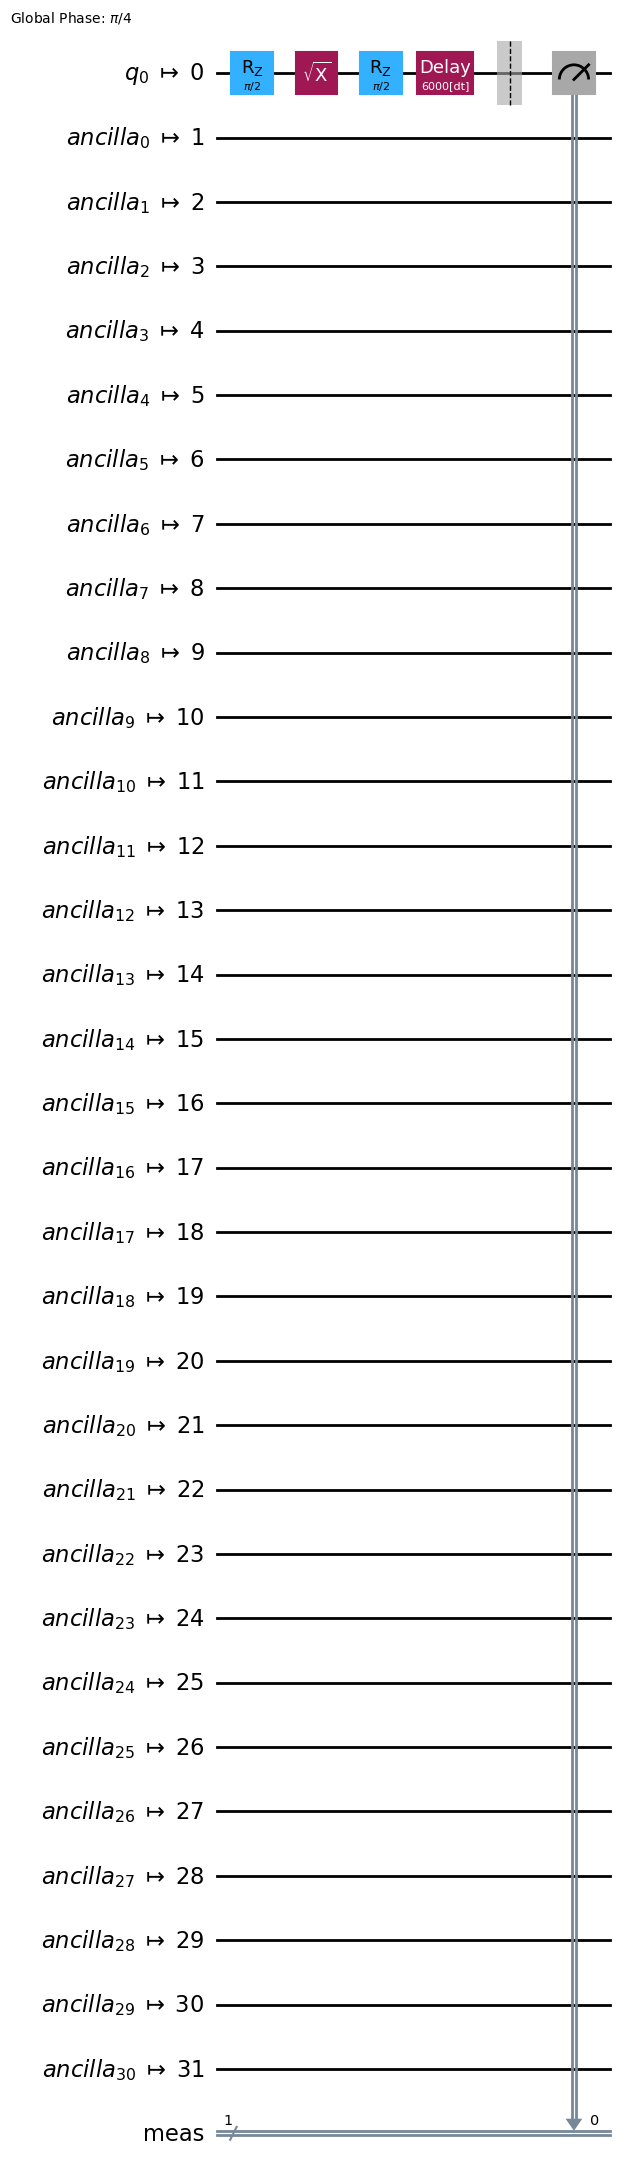

In [6]:
list_circuits

# We can compare the differences between the ideal and the transpiled circuits

display(list_circuits[1].draw("mpl"))
display(list_transpiled_circuits[1].draw("mpl"))

In [7]:
# We can run now the experiments.
for exp_info_i, transpiled_circ_i in zip(list_of_experiments, list_transpiled_circuits):
    print(exp_info_i)
    n_shots = exp_info_i.n_shots
    results = backend.run(
        transpiled_circ_i, shots=int(n_shots), output_qasm3=True
    ).result()
    counts = results.get_counts()
    counts_0 = counts.get("0", 0)

    results_logger.log(exp_info_i, counts_0)

    print(counts)

# When we finish all the experiments, we flush to write the results in the buffer
results_logger.flush()


myExperiment(initial_state='0', delay_time=1e-05, qubit_id=0, n_shots=1000)
{'0': 1000}
myExperiment(initial_state='+', delay_time=3e-06, qubit_id=0, n_shots=1000)
{'0': 559, '1': 441}


In [8]:
import pandas as pd

pd.read_parquet("aux/temp.parquet")

,initial_state,delay_time,qubit_id,n_shots,result,datetime,exp_id
0,0,0.000010,0,1000,1000,2025-05-06T18:25:33.355612,8c14483940d881f381e04c5f219b27516717fd3c17ccc4...
1,+,0.000003,0,1000,559,2025-05-06T18:25:33.418350,1b21fa0530065d42118d7aa625cdb469dfa802c155205c...


Si intentamos ejecutar circuitos que ya se han guardado (es decir, tienen mismo exp_id), no se guardarán

# Loop para evitar gastar recursos 

In [ ]:
for exp_info_i, transpiled_circ_i in zip(list_of_experiments, list_transpiled_circuits):
    if exp_info_i.exp_id() in results_logger.done_ids:
        logger.info(f"Skipping already done exp_id={exp_info_i.exp_id()}")
        continue
    print(exp_info_i)
    n_shots = exp_info_i.n_shots
    results = backend.run(
        transpiled_circ_i, shots=int(n_shots), output_qasm3=True
    ).result()
    counts = results.get_counts()
    counts_0 = counts.get("0", 0)

    results_logger.log(exp_info_i, counts_0)

    print(counts)

results_logger.flush()

pd.read_parquet("aux/temp.parquet")

,initial_state,delay_time,qubit_id,n_shots,result,datetime,exp_id
0,0,0.000010,0,1000,1000,2025-05-06T18:25:33.355612,8c14483940d881f381e04c5f219b27516717fd3c17ccc4...
1,+,0.000003,0,1000,559,2025-05-06T18:25:33.418350,1b21fa0530065d42118d7aa625cdb469dfa802c155205c...
